In [8]:
#import networkx as nx
import numpy as np
#import seaborn as sb
#import scipy
import matplotlib.pyplot as plt
import cvxpy as cp

# Matrix Generation

### Utility Functions

In [ ]:
sample = np.random.sample

In [ ]:
#Given a list of weights, will pick a random index with likelihood corresponding to the weight
def pickRandomIndex(weights,total):
    t = sample() * total;
    i = 0;
    for w in weights:
        t -= w
        if t < 0:
            return i;
        i += 1;
    raise ValueError('total is bigger than the sum of weights')

### Generation Functions

In [ ]:
#random matrix with edge density p
def randomPMatrix(n,p):
    A = np.zeros([n,n]);
    for i in range(1,n):
        for j in range(i):
            if sample() < p:
                A[i,j] = 1;
                A[j,i] = 1;
    return A

In [ ]:
#random d-regular graph
errorbound = 10;

def randomDRegular(n,d):
    A = np.ones([1,1]) * -1
    #num = 1
    while A[0,0] == -1:
        A = tryRandomDRegular(n,d)
        #print("n = ",n, "\n Attempt:",num)
        #num += 1
    return A


def tryRandomDRegular(n,d):
    A = np.zeros([n,n]);
    weights = d*np.ones([n]);
    total = d*n
    error = 0;
    while total > 0:
        i = pickRandomIndex(weights, total)
        j = pickRandomIndex(weights, total)
        if i != j and A[i,j] == 0:
            A[i,j] = 1
            A[j,i] = 1
            weights[i] -= 1
            weights[j] -= 1
            total -= 2
            error = 0
        else:
            error += 1
        if error >= errorbound:
            return np.ones([1,1])*-1
    return A

In [ ]:
#random d-regular graph
def modifiedRandomDRegular(n,d):
    A = np.ones([1,1]) * -1
    while A[0,0] == -1:
        A = RandomDRegularAttempt(n,d)
    return A

def RandomDRegularAttempt(n,d):
    A = np.zeros([n,n]);
    #Amount of edges still needed for each vertex and in total
    weights = d*np.ones([n]);
    total = d*n
    while total > 0:
        i = pickRandomIndex(weights, total)
        #weights altered for index i to exclude vertex i and any vertex j already connected to i
        iWeights = np.zeros([n]);
        iTotal = 0;
        for j in range(n):
            if(i != j and A[i,j] == 0):
                iWeights[j] = weights[j]
                iTotal += weights[j]
        if(iTotal == 0):
            #Vertex i has less than d connections but has no possible connections left
            return np.ones([1,1])*-1
        j = pickRandomIndex(iWeights, iTotal)
        #connect i and j
        A[i,j] = 1
        A[j,i] = 1
        weights[i] -= 1
        weights[j] -= 1
        total -= 2
    return A

In [ ]:
#random Barabási–Albert small world graph
#Note that every vertex we add will add m connections and thus increase total degree by 2m
#Therefore for n -> \infinity we see that the average degree will approach 2m

def BASmallWorld(n,m):
    A = np.zeros([n,n]);
    weights = np.zeros([n]);
    for i in range(m):
        weights[i] = 1
        A[i,m] = 1
        A[m,i] = 1
    weights[m] = m
    total = 2*m
    for i in range(m + 1,n):
        d = m
        while d > 0:
            j = pickRandomIndex(weights,total)
            if i != j and A[i,j] == 0:
                A[i,j] = 1
                A[j,i] = 1
                weights[i] += 1
                weights[j] += 1
                total += 1
                d -= 1
        total += m
    return A

In [ ]:
#random Watts–Strogatz small world graph
#Note: input K/2 instead of K
def WSSmallWorld(n,K, b):
    A = np.zeros([n,n]);
    for i in range(n):
        for k in range(K):
            j = np.mod(i + 1 + k,n)
            A[i,j] = 1
            A[j,i] = 1
    for i in range(n):
        for k in range(K):
            #chance = beta to rewire
            if sample() < b:

                j = np.mod(i + 1 + k, n)
                l = j
            
                #find l that i is not connected to
                while A[i,l] == 1 or i == l:
                    l = np.random.randint(n)
                
                #rewire to l
                A[i,j] = 0
                A[j,i] = 0
                A[i,l] = 1
                A[l,i] = 1
    return A

### Matrix Preperation

In [ ]:
#How does the average Degree depend on n?
def averageDegree(n):
    return 2*int(np.ceil(np.sqrt(n)))

In [ ]:
#Utility function
def phiSquared(A):
    u, V = np.linalg.eigh(A)
    return np.array(np.multiply(V, V))

In [ ]:
#Generate matrices for different sizes
matrixSizes = np.arange(25,400,25)

pAdjMatrices = []
dRegularAdjMatrices = []
BAAdjMatrices = []
WSAdjMatrices = []
rewireChance = .3

for i in range(matrixSizes.shape[0]):
    n = matrixSizes[i]
    k = averageDegree(n)
    
    pAdjMatrices.append(randomPMatrix(n, k/n))
    dRegularAdjMatrices.append( randomDRegular(n,k))
    BAAdjMatrices.append( BASmallWorld(n, np.floor(k/2).astype(int)))
    WSAdjMatrices.append( WSSmallWorld(n, np.floor(k/2).astype(int), rewireChance))

#Transform adjacency matrix to \Phi^2
pMatrices = list(map(phiSquared, pAdjMatrices))
dRegularMatrices = list(map(phiSquared, dRegularAdjMatrices))
BAMatrices = list(map(phiSquared, BAAdjMatrices))
WSMatrices = list(map(phiSquared, WSAdjMatrices))

In [ ]:
#Run individual lists/entries to view the results
#WSMatrices

# Methods

## Standard Methods

In [ ]:
#supremum lower
def sup_lower_approx(VV, n):
    return int(np.ceil(1/np.max(VV)))

In [ ]:
#greedy lower
def lower_approx(VV, n):
    vflat = VV.reshape(n*n)
    res = 0
    count = 0
    sorted = np.argsort(vflat)
    while res < 1:
        count += 1
        res += vflat[sorted[-count]]
    return count

In [ ]:
#linear lower
def linear_approx(V2, n):
    x = cp.Variable(n)
    y = cp.Variable(n)
    u = cp.Variable((n,n))

    c1 = cp.sum(cp.multiply(V2, u))
    cx = cp.reshape(x,(n,1)) @ cp.reshape(np.ones([1,n]),(1,n))
    cy = cp.reshape(np.ones([1,n]),(n,1)) @ cp.reshape(y,(1,n))

    constraints = [cp.vec(u) >= 0, cp.vec(u) <= 1, 
                   0 <= x, x <= 1, 0 <= y, y <= 1, 
                   c1 >= 1, u <= cx, u <= cy, cx + cy - 1  <= u
                   ]
    prob = cp.Problem(cp.Minimize(cp.sum(u)),constraints)
    sol = prob.solve()
    #print("x = ", x.value)
    #print("y = ", y.value)
    #print("u = ", u.value)
    #print("sol = ", np.ceil(sol))
    return int(np.ceil(sol)), x.value, y.value

In [ ]:
#sdp lower
def sdp_approx(VV, n):
    x = cp.Variable(2*n)
    u = cp.Variable((2*n,2*n))
    
    Z = np.zeros((n,n))
    O = np.ones((n,n))
    Vsym = np.concatenate((np.concatenate((Z,0.5*VV), axis =1), np.concatenate((0.5*VV.T, Z), axis =1)))
    Idsym = np.concatenate((np.concatenate((Z,0.5*O), axis =1), np.concatenate((0.5*O, Z), axis =1)))

    c1 = cp.sum(cp.multiply(Vsym, u))
    cx = cp.reshape(x,(2*n,1)) @ cp.reshape(np.ones([1,2*n]),(1,2*n))
    cy = cp.reshape(np.ones([1,2*n]),(2*n,1)) @ cp.reshape(x,(1,2*n))
    ctrace = cp.trace(u - cp.diag(x))
    
    A11= cp.reshape(1, (1, 1))
    A12= cp.reshape(x, (1, 2*n))
    A1 = cp.hstack([A11, A12])

    A21= cp.reshape(x, (2*n,1))
    A22= u
    A2 = cp.hstack([A21, A22])
    M = cp.vstack([A1, A2])
    

    constraints = [cp.vec(u) >= 0, cp.vec(u) <= 1, 0 <= x, x <= 1, c1 >= 1, u <= cx, u <= cy, cx + cy - 1  <= u, ctrace == 0, M >> 0]
    prob = cp.Problem(cp.Minimize(cp.sum(cp.multiply(Idsym, u))), constraints)
    return int(np.ceil(prob.solve()))

In [ ]:
#k-width upper
def upper_bound_2(VV, n):
    res = n
    for i in range(n):
        for j in range(i+1,n):
            ind_subset = np.array([i,j])
            VV_tr = VV[ind_subset, :]
            sums = np.sum(VV_tr, axis = 0)
            argsorted_sums = np.argsort(sums)
            cumsum = 0
            count = 0
            while cumsum < 1:
                count += 1
                cumsum += sums[argsorted_sums[-count]]
            if count*2 < res:
                res = count*2

            VV_tr = VV[:,ind_subset]
            sums = np.sum(VV_tr, axis = 1)
            argsorted_sums = np.argsort(sums)
            cumsum = 0
            count = 0
            while cumsum < 1:
                count += 1
                cumsum += sums[argsorted_sums[-count]]

            if count*2 < res:
                res = count*2
    
    return res

In [ ]:
#kwidth upper for k = 3
def upper_bound_3(VV, n):
    res = n
    for i in range(n):
        print('working...', i)
        for j in range(i+1,n):
            for t in range(j+1, n):
                ind_subset = [i,j,t]
                VV_tr = VV[ind_subset, :]
                sums = np.sum(VV_tr, axis = 0)
                argsorted_sums = np.argsort(sums)
                cumsum = 0
                count = 0
                while cumsum < 1:
                    count += 1
                    cumsum += sums[argsorted_sums[-count]]
                if count*3 < res:
                    res = count*3

                
                VV_tr = VV[:,ind_subset]
                sums = np.sum(VV_tr, axis = 1)
                argsorted_sums = np.argsort(sums)
                cumsum = 0
                count = 0
                while cumsum < 1:
                    count += 1
                    cumsum += sums[argsorted_sums[-count]]
                if count*3 < res:
                    res = count*3
    return np.min(res)

## Custom Methods

### Linear Modification

In [ ]:
#custom linear
def linear_mod_round(V2, n, rx, ry):
    x = cp.Variable(n)
    y = cp.Variable(n)
    u = cp.Variable((n,n))

    c1 = cp.sum(cp.multiply(V2, u))
    cx = cp.reshape(x,(n,1)) @ cp.reshape(np.ones([1,n]),(1,n))
    cy = cp.reshape(np.ones([1,n]),(n,1)) @ cp.reshape(y,(1,n))

    constraints = [cp.vec(u) >= 0, cp.vec(u) <= 1, 
                   0 <= x, x <= 1, 0 <= y, y <= 1, 
                   x >= rx, x <= rx + 1, y >= ry, y <= ry + 1,
                   c1 >= 1, u <= cx, u <= cy, cx + cy - 1  <= u
                   ]
    prob = cp.Problem(cp.Minimize(cp.sum(u)),constraints)
    sol = prob.solve()
    #print("x = ", x.value)
    #print("y = ", y.value)
    #print("u = ", u.value)
    return int(np.ceil(sol)),x.value, y.value

In [ ]:
def linear_mod(V2, n):
    rx = np.zeros(n)
    ry = np.zeros(n)
    
    res = n
    res_y = []
    res_x = []
    for i in range(n):
        print("Round: ", i)
        rx[i] = 1
        sol, x, y = linear_mod_round(V2,n, rx, ry)
        if sol < res:
            res_y = y
            res_x = x
            res = sol
        rx[i] = -1
    return res, res_x, res_y

### No-gaps/Greedy Modification

In [ ]:
#Utility functions for no_gaps_mod
def sortsum(c):
    a = np.sort(c)[::-1]
    return np.cumsum(a) - a

def sortsummatrix(VV):
    n = VV.shape[0]
    A = np.zeros(VV.shape);
    for i in range(n):
        A[i,:] = sortsum(VV[i,:])
    return A

In [ ]:
sortsummatrix(np.array([[1,2],[3,4]]))

In [ ]:
def no_gaps_round(VV,n,P,S):
    VV_tr = VV[:,S]
    sums = np.sum(VV_tr, axis = 1)

    S_size = len(S)
    res = n
    K  = []
    
    for i in range (S_size,n):
        if i*S_size > res:
            break # We restrict ourselves to the case where there are at least s rows and columns
           
        #Add the restricted sum, to the best remaining i - 2 elements in the row
        T = sums + P[:, i - 2]
        Targs = np.argsort(T)
        T = np.sort(T)[::-1]
        
        #keep selecting the best rows until we exceed 1
        cumsum = 0
        count = 0
        while cumsum < 1:
            cumsum += T[count]
            count += 1
                
        if i*count < res:
            res = i*count
            K = Targs[:count]
    return res, K

In [ ]:
#custom greedy
def no_gaps_mod(VV, n):
    P = sortsummatrix(VV)
    res = n
    K = []
    for ki in range(n-1):
        for kj in range(ki+1,n):
            #sum up each row restricted to ki, kj
            ind_subset = [ki,kj]
            round_sol, round_K = no_gaps_round(VV, n, P, ind_subset)
            if round_sol < res:
                res = round_sol
                K = round_K
    return res, K

In [ ]:
# Upper bound from no_gaps_mod
def FindRestrictedOptimum(VV,n,K):
    VV_tr = VV[K, :]
    sums = np.sum(VV_tr, axis = 0)
    argsorted_sums = np.argsort(sums)
    cumsum = 0
    count = 0
    while cumsum < 1:
        count += 1
        cumsum += sums[argsorted_sums[-count]]
    return count * K.size

# Experiments

## Linear Method Experiments

In [ ]:
# Demonstrate the distribution of x for case n = 350
VV = pMatrices[14]
n = matrixSizes[14]

sol, x, y = linear_approx(VV, n)
print("normal linear:\nvalue:", sol, "\ny:", y)
sol_mod, x_mod, y_mod = linear_mod(VV, n)
print("modified linear:\nvalue:", sol_mod, "\ny:", y_mod)

In [ ]:
sol = 12
y = [0.32328862 0.32328961 0.32329102 0.3232934  0.32328905 0.32329259
 0.32329289 0.32329259 0.32329335 0.32329218 0.5        0.32329179
 0.5        0.323293   0.35819229 0.32328955 0.32329026 0.32329341
 0.32329216 0.32329367 0.32329263 0.5        0.32329311 0.3232907
 0.32329206 0.32328846 0.32451336 0.32329348 0.32328933 0.32329307
 0.32329353 0.32329089 0.32329665 0.32329217 0.3232938  0.32329201
 0.32329139 0.32329009 0.32329431 0.5        0.32329055 0.32329971
 0.3232907  0.32329272 0.3232936  0.32328923 0.32329117 0.32329338
 0.32329297 0.32329426 0.32328599 0.32329289 0.32329392 0.32329406
 0.32329209 0.32333534 0.32328845 0.32329136 0.32328772 0.32329338
 0.32329492 0.32329309 0.32329036 0.32328806 0.5        0.32329372
 0.323293   0.32333031 0.32328071 0.32328958 0.32329333 0.32329241
 0.32329377 0.32329237 0.32329298 0.32329412 0.32329463 0.32329324
 0.32329153 0.32329359 0.32328634 0.32329269 0.32329246 0.32329264
 0.32328916 0.32329226 0.32329304 0.32328867 0.5        0.32329325
 0.32329437 0.32329429 0.32329267 0.32329211 0.32328931 0.32329343
 0.32329437 0.5        0.32329376 0.32328857 0.32330054 0.32328948
 0.32328996 0.32329322 0.32329226 0.32329198 0.32328944 0.5
 0.3232924  0.32329376 0.32329287 0.32329352 0.5        0.32329133
 0.5        0.322168   0.3232938  0.32328354 0.32328811 0.5
 0.32329414 0.32329371 0.32329204 0.32328822 0.32328893 0.3232929
 0.32328948 0.32328911 0.5        0.32329237 0.5        0.32328949
 0.32329316 0.32329215 0.32329369 0.32329304 0.3232915  0.32329401
 0.32329482 0.32329293 0.32329144 0.32329033 0.32328684 0.32329342
 0.3232919  0.32329163 0.32328768 0.32328954 0.32329236 0.32329272
 0.5        0.32329001 0.32328925 0.5        0.32328228 0.32329085
 0.5        0.5        0.32326604 0.32328941 0.5        0.3232915
 0.32329262 0.5        0.32329355 0.32329434 0.32328765 0.32329502
 0.32328759 0.32332537 0.32329309 0.5        0.32328771 0.32329288
 0.32329357]
sol_mod = 17
y_mod = [5.00000000e-01 4.70052410e-13 5.92132907e-13 4.69006454e-13
 4.72563000e-13 5.04000494e-12 4.97697090e-13 5.77843734e-13
 4.68881742e-13 4.81080786e-13 5.31151702e-13 4.70424477e-13
 5.36549934e-13 4.70992031e-13 4.72954308e-13 4.70540595e-13
 6.13058004e-13 4.69232074e-13 4.69696326e-13 4.69983583e-13
 4.68989431e-13 4.75303431e-13 4.68734504e-13 1.03483367e-12
 4.73441213e-13 4.71286711e-13 4.85301004e-13 6.34355093e-13
 4.90706813e-13 4.75141129e-13 4.76574063e-13 4.69900155e-13
 5.21762074e-13 6.69645169e-13 4.73083701e-13 5.32867460e-13
 4.69651147e-13 4.80076175e-13 4.77040354e-13 4.69024293e-13
 4.71800312e-13 4.69707580e-13 4.72232808e-13 4.75622419e-13
 4.69141648e-13 5.30489571e-13 4.79737240e-13 4.73591776e-13
 7.45909252e-13 1.04013810e-12 4.92171547e-13 4.68900119e-13
 5.00083374e-13 5.73012598e-13 6.24540171e-13 4.82399129e-13
 4.87706917e-13 4.83711722e-13 1.23352588e-12 5.16775688e-13
 1.32879621e-01 7.72579705e-13 5.14604508e-13 5.59326369e-13
 4.78818292e-13 5.00000000e-01 4.68824670e-13 4.70079554e-13
 4.79478276e-13 4.84984127e-13 5.34367811e-13 4.78197918e-13
 5.49883429e-13 4.77718795e-13 5.47860032e-13 6.54320208e-13
 5.25623905e-13 5.00000000e-01 1.26110699e-12 5.89938197e-13
 5.00000000e-01 1.31095836e-12 2.11882985e-12 5.00000000e-01
 5.99608768e-13 5.00000000e-01 4.70524911e-13 5.00000000e-01
 4.73711014e-13 5.00000000e-01 5.00000000e-01 1.99312974e-12
 1.11452615e-12 1.08469952e-12 5.00000000e-01 5.00000000e-01
 6.09923742e-13 4.69171470e-13 5.44031163e-13 3.36956847e-10
 4.82920945e-13 5.44893522e-13 9.74307673e-13 7.56113673e-13
 5.72178248e-13 4.73584767e-13 9.07096573e-13 4.70714636e-13
 5.34529790e-13 6.12507549e-13 4.87724064e-13 5.84623922e-13
 5.22438647e-13 5.09986827e-13 4.80362196e-13 5.20964047e-13
 5.05720110e-13 4.69899611e-13 5.12187960e-13 4.82645428e-13
 4.84764525e-13 5.42557566e-13 4.70634554e-13 4.72264646e-13
 5.44317741e-13 5.70459370e-13 4.77392570e-13 5.35503155e-13
 5.25454337e-13 4.81497036e-13 4.76005428e-13 4.71024486e-13
 6.86742723e-13 4.69172523e-13 4.71024322e-13 5.18970591e-13
 5.00000000e-01 4.72512797e-13 4.69450389e-13 4.73770513e-13
 5.87352655e-13 6.26502899e-13 4.73411644e-13 4.76118745e-13
 4.71033459e-13 6.58287971e-13 4.84020443e-13 4.77543376e-13
 4.69455612e-13 4.68920837e-13 4.68986199e-13 4.72512992e-13
 5.71132630e-13 4.69251931e-13 4.72591413e-13 4.71353109e-13
 5.42110338e-13 4.75541716e-13 4.70068122e-13 4.74779901e-13
 5.20535355e-13 4.70472016e-13 4.69177471e-13 6.91364009e-13
 6.69716998e-13 5.91625377e-13 7.44381508e-13 7.60025517e-13
 4.77308029e-13 5.95361040e-13 8.44951995e-13 4.87830288e-13
 5.00000000e-01 4.76565122e-13 4.69067885e-13]

In [ ]:
# Show improved distribution of x for our new method
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=2.0)
axs[0].plot(y, marker='.', color='blue', ls='')
axs[0].set_title('linear')

axs[1].plot(y_mod, marker='.', color='orange', ls='')
axs[1].set_title('modified linear')

y_chosen = 0
for yi in y:
    if yi>.4:
        y_chosen += 1
        
y_mod_chosen = 0
for yi in y_mod:
    if yi > .1:
        y_mod_chosen += 1

print("Linear Chosen Columns:", y_chosen)
print("Modified Linear Columns:", y_mod_chosen)

In [ ]:
# Improved lower bound

## Comparing Matrix Types

In [ ]:
# Compare the distribution of degrees for n = 350
index = 14

pDegrees = np.sum(pAdjMatrices[index], axis = 0)
dDegrees = np.sum(dRegularAdjMatrices[index], axis = 0)
BADegrees = np.sum(BAAdjMatrices[index], axis = 0)
WSDegrees = np.sum(WSAdjMatrices[index], axis = 0)

pLeg = plt.plot(np.sort(pDegrees), '.', label='pMatrices')
dReg = plt.plot(np.sort(dDegrees), '.', label='dRegMat')
BALeg = plt.plot(np.sort(BADegrees), '.', label='BA')
WSLeg = plt.plot(np.sort(WSDegrees), '.', label='WS')
plt.legend(["p","dReg","BA","WS"])

In [ ]:
# Compare the distribution of coordinates in \Phi

index = 14
n = matrixSizes[index]

pEig =  pMatrices[index].reshape(n*n)
dEig =  dRegularMatrices[index].reshape(n*n)
BAEig = BAMatrices[index].reshape(n*n)
WSEig = WSMatrices[index].reshape(n*n)

fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=2.0)
axs[0, 0].plot(np.sort(pEig)[::-1], marker='.', color='blue', ls='')
axs[0, 0].set_title('p')

axs[0, 1].plot(np.sort(dEig)[::-1], marker='.', color='orange', ls='')
axs[0, 1].set_title('dReg')

axs[1, 0].plot(np.sort(BAEig)[::-1], marker='.', color='green', ls='')
axs[1, 0].set_title('BA')

axs[1, 1].plot(np.sort(WSEig)[::-1], marker='.', color='red', ls='')
axs[1, 1].set_title('WS')

In [ ]:
index = 6
n = matrixSizes[index]

pEig =  pMatrices[index].reshape(n*n)
dEig =  dRegularMatrices[index].reshape(n*n)
BAEig = BAMatrices[index].reshape(n*n)
WSEig = WSMatrices[index].reshape(n*n)

plt.plot(np.sort(pEig)[::-1], marker='.', color='blue', ls='')
plt.plot(np.sort(dEig)[::-1], marker='.', color='orange', ls='')
plt.plot(np.sort(BAEig)[::-1], marker='.', color='green', ls='')
plt.plot(np.sort(WSEig)[::-1], marker='.', color='red', ls='')
plt.legend(["p","dReg", "BA", "WS"])

# Results

In [ ]:
#Choose the type of matrices here

#VV = pMatrices
VV = dRegularMatrices
#VV = BAMatrices
#VV = WSMatrices

In [ ]:
#Run simple bounds on every matrix type
#Time: +- 2 minutes
m = matrixSizes.size

greedy = []
sup = []
kwidth = []
linear = []

for i in range(m):
    n = matrixSizes[i]
    print("size:", n)
    kwidth.append(upper_bound_2(VV[i],n))
    greedy.append(lower_approx(VV[i],n))
    sup.append(sup_lower_approx(VV[i],n))
    sol, x, y = linear_approx(VV[i],n)
    linear.append(sol)

print("greedy = ", greedy)
print("sup = ", sup)
print("kwidth = ", kwidth)
print("linear = ", linear)

In [ ]:
#Modified greedy
#time: 4 minutes
m = matrixSizes.size
no_gaps = []
upper_mod = []

for i in range(14):
    n = matrixSizes[i]
    print("size:", n)
    sol, K = no_gaps_mod(VV[i],n)
    no_gaps.append(sol)
    print("sol = ", sol)
    print("K = ",K)
    upper_mod.append(FindRestrictedOptimum(VV[i],n,K))

print("no_gaps = ", no_gaps)
print("upper_mod = ", upper_mod)

In [ ]:
#Modified Linear
#Time: Expected +- 4 hours
m = matrixSizes.size
mod_linear = []
for i in range(14):
    n = matrixSizes[i]
    print("size:", n)
    sol, x, y = linear_mod(VV[i],n)
    mod_linear.append(sol)
    print("mod_linear = ", mod_linear)

In [ ]:
#SDP
#note that we limit the amount of matrices we consider
#Time: 1.5 hours

m = matrixSizes.size

sdp_lower = []

for i in range(3):
    n = matrixSizes[i]
    print("size:", n)
    sdp_lower.append(sdp_approx(VV[i],n))
    print("sdp_lower = ", sdp_lower)

print("sdp_lower = ", sdp_lower)


In [9]:
#Results:

#Paste your results here in different lists
#Comment which type of graph you consider: WS
greedy_res = [
    [5, 6, 8, 10, 11, 11, 14, 14, 17, 18, 20, 21, 22, 24, 26]
,
    [4, 6, 7, 9, 11, 14, 13, 15, 16, 17, 19, 20, 22, 24, 25],
    [5, 6, 8, 9, 10, 13, 13, 16, 15, 18, 21, 22, 22, 25, 26],
    [4, 6, 8, 8, 12, 13, 15, 16, 19, 18, 19, 21, 24, 24, 24],
    [4, 6, 8, 10, 11, 12, 14, 16, 17, 19, 19, 21, 22, 25, 27]
]

sup_res = [
    [4, 5, 7, 9, 10, 8, 12, 11, 12, 15, 14, 16, 14, 21, 19],
    [4, 6, 6, 8, 10, 12, 9, 12, 12, 13, 14, 17, 19, 20, 21],
    [4, 6, 7, 6, 8, 12, 11, 12, 12, 15, 17, 18, 18, 21, 21],
    [3, 5, 7, 6, 8, 11, 12, 10, 15, 15, 16, 18, 19, 20, 18],
    [4, 5, 6, 8, 9, 10, 10, 12, 13, 15, 14, 14, 17, 21, 21]
]

linear_res = [
    [5, 7, 9, 11, 12, 13, 15, 16, 19, 20, 22, 23, 24, 26, 28],
    [5, 7, 8, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 26, 27],
    [5, 7, 8, 10, 11, 14, 15, 18, 18, 20, 22, 24, 24, 27, 27],
    [4, 7, 9, 9, 13, 14, 16, 18, 20, 20, 22, 23, 26, 26, 27],
    [5, 7, 9, 10, 12, 14, 16, 17, 18, 21, 21, 23, 24, 27, 28]
]

kwidth_res = [
    [8, 14, 20, 28, 36, 44, 50, 58, 64, 74, 82, 88, 100, 106, 114],
    [8, 14, 22, 26, 36, 44, 50, 58, 64, 74, 80, 86, 96, 104, 112],
    [10, 14, 20, 28, 36, 40, 50, 58, 64, 72, 80, 90, 96, 106, 108],
    [8, 14, 20, 26, 34, 40, 50, 58, 64, 74, 82, 88, 98, 102, 114],
    [8, 14, 20, 24, 34, 44, 50, 56, 64, 74, 82, 90, 96, 106, 112]
]

greedy_mod_res = [
    [6, 8, 12, 15, 16, 20, 24, 24, 28, 30, 35, 35, 36, 40, 42],
    [6, 8, 12, 12, 18, 20, 20, 24, 28, 28, 32, 35, 40, 40, 44],
    [6, 9, 12, 12, 15, 20, 20, 25, 28, 30, 35, 35, 40, 42, 44],
    [6, 8, 12, 12, 18, 20, 24, 25, 30, 32, 35, 35, 40, 40, 42],
    [6, 8, 12, 14, 16, 20, 21, 25, 30, 32, 32, 35, 36, 42, 42]
]

linear_mod_res = [6, 10, 12, 15, 18, 20, 23, 24, 27, 29, 32, 34]
sdp_res = [7, 8, 12, 13, 16, 17, 19, 22, 23]

#mod k-width / greedy upper
# [14, 28, 34, 45, 60, 80, 92, 104, 112, 132, 140, 147, 150, 184, 182]
# [16, 22, 42, 51, 60, 68, 90, 96, 119, 126, 136, 140, 160, 184, 209]
#[16, 24, 42, 54, 60, 76, 85, 100, 119, 114, 140, 140, 168, 175, 209]
#[14, 26, 40, 51, 60, 72, 90, 95, 114, 128, 140, 154, 176, 184, 182]
#[14, 28, 36, 48, 60, 80, 78, 95, 105, 116, 152, 147, 171, 175, 196]

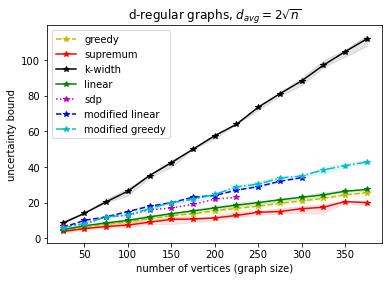

In [10]:
ran = range(25,400,25) #matrixSizes
plt.title('d-regular graphs, $d_{avg}= 2\sqrt{n}$')
plt.plot(ran, np.mean(greedy_res, axis = 0),       'y*--', label = 'greedy')
plt.plot(ran, np.mean(sup_res, axis = 0),          'r*-',  label = 'supremum')
plt.plot(ran, np.mean(kwidth_res, axis = 0),       'k*-',  label = 'k-width')
plt.plot(ran, np.mean(linear_res, axis = 0),       'g*-',  label = 'linear')
plt.plot(ran[:9], sdp_res,               'm*:',  label = 'sdp')

plt.plot(ran[:12], linear_mod_res,            'b*--',  label = 'modified linear')
plt.plot(ran, np.mean(greedy_mod_res, axis = 0),      'c*-.',  label = 'modified greedy')

plt.fill_between(ran, np.min(greedy_res, axis =0), np.max(greedy_res, axis =0), color='y', alpha=0.1)
plt.fill_between(ran, np.min(sup_res,    axis =0), np.max(sup_res,    axis =0), color='r', alpha=0.1)
plt.fill_between(ran, np.min(kwidth_res, axis =0), np.max(kwidth_res, axis =0), color='k', alpha=0.1)
plt.fill_between(ran, np.min(linear_res, axis =0), np.max(linear_res, axis =0), color='g', alpha=0.1)
plt.fill_between(ran, np.min(greedy_mod_res, axis =0), np.max(greedy_mod_res, axis =0), color='c', alpha=0.1)


plt.xlabel("number of vertices (graph size)")
plt.ylabel("uncertainty bound")
plt.legend()
plt.savefig("dregDsqrt.png")
